In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# ==============================
# ConvNeXt (No Fine-Tuning) for Paddy Leaf Dataset
# ==============================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ==============================
# PATHS (Adjust for Kaggle)
# ==============================
train_dir = "/kaggle/input/paddy-leaf-small/Small-80/train"
test_dir = "/kaggle/input/paddy-leaf-small/Small-80/test"
pretrained_weights = "/kaggle/input/convnext/convnext_tiny_notop.h5"

img_size = 224
batch_size = 32
seed = 42

# ==============================
# DATA AUGMENTATION (60:20:20)
# ==============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset="validation"
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
print(f"✅ Classes: {num_classes}")

# ==============================
# MODEL ARCHITECTURE (ConvNeXt Frozen)
# ==============================
base_model = ConvNeXtTiny(
    include_top=False,
    weights=pretrained_weights,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False  # ❌ No fine-tuning

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==============================
# CALLBACKS
# ==============================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_convnext_model.h5', monitor='val_accuracy', save_best_only=True)

# ==============================
# TRAIN MODEL (No Fine-Tuning)
# ==============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

# ==============================
# EVALUATION
# ==============================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

# ==============================
# PLOT TRAINING CURVES
# ==============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# ==============================
# CONFUSION MATRIX & CLASS REPORT
# ==============================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ==============================
# PARAMETERS & WEIGHTS
# ==============================
print(f"\n📦 Total Parameters: {model.count_params()}")
for layer in model.layers:
    print(f"{layer.name}: {len(layer.get_weights())} weight tensors")

# ==============================
# GFLOPs CALCULATION
# ==============================
def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(tf.TensorSpec([1, img_size, img_size, 3], tf.float32))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    tf_graph = frozen_func.graph

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(tf_graph.as_graph_def(), name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

flops = get_flops(model)
print(f"\n⚡ Approx GFLOPs: {flops/1e9:.3f} GFLOPs")


Found 4160 images belonging to 13 classes.
Found 1040 images belonging to 13 classes.
✅ Classes: 13


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,267,053 (111.64 MB)

 Trainable params: 1,446,925 (5.52 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 77s 428ms/step - accuracy: 0.0779 - loss: 2.8267
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 422ms/step - accuracy: 0.0760 - loss: 2.6123
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 395ms/step - accuracy: 0.0959 - loss: 2.5834
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 386ms/step - accuracy: 0.0820 - loss: 2.5785
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 402ms/step - accuracy: 0.0933 - loss: 2.5577
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 420ms/step - accuracy: 0.0986 - loss: 2.5450
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 53s 403ms/step - accuracy: 0.1179 - loss: 2.5295
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 389ms/step - accuracy: 0.1460 - loss: 2.4922
Epoch 9/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 391ms/step - accuracy: 0.1447 - loss: 2.4738
Epoch 10/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 53s 409ms/step - accuracy: 0.1709 - loss: 2.4233
Epoch 11/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 426ms/step - accuracy: 0.1889 - loss: 2.3800
Epoch 12/50
130/130

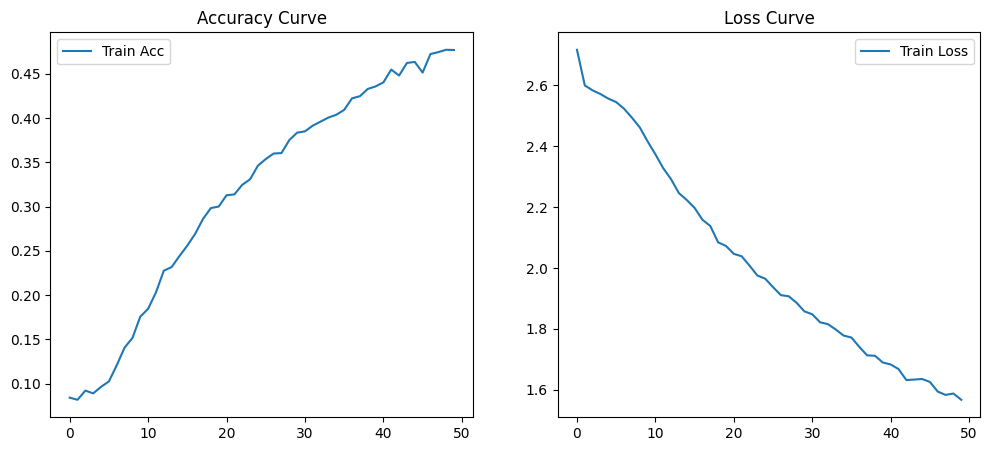

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step

Classification Report:
                           precision    recall  f1-score   support

   bacterial_leaf_blight       0.36      0.70      0.48        80
   bacterial_leaf_streak       0.68      0.78      0.73        80
bacterial_panicle_blight       0.59      0.78      0.67        80
        black_stem_borer       0.62      0.60      0.61        80
                   blast       0.49      0.41      0.45        80
              brown_spot       0.60      0.45      0.51        80
            downy_mildew       0.42      0.40      0.41        80
                   hispa       0.37      0.19      0.25        80
             leaf_roller       0.54      0.53      0.53        80
                  normal       0.44      0.38      0.41        80
                  tungro       0.44      0.44      0.44        80
        white_stem_borer       0.47      0.31      0.38        80
       yellow_stem_borer       0.77      0.86      0.81        80

       

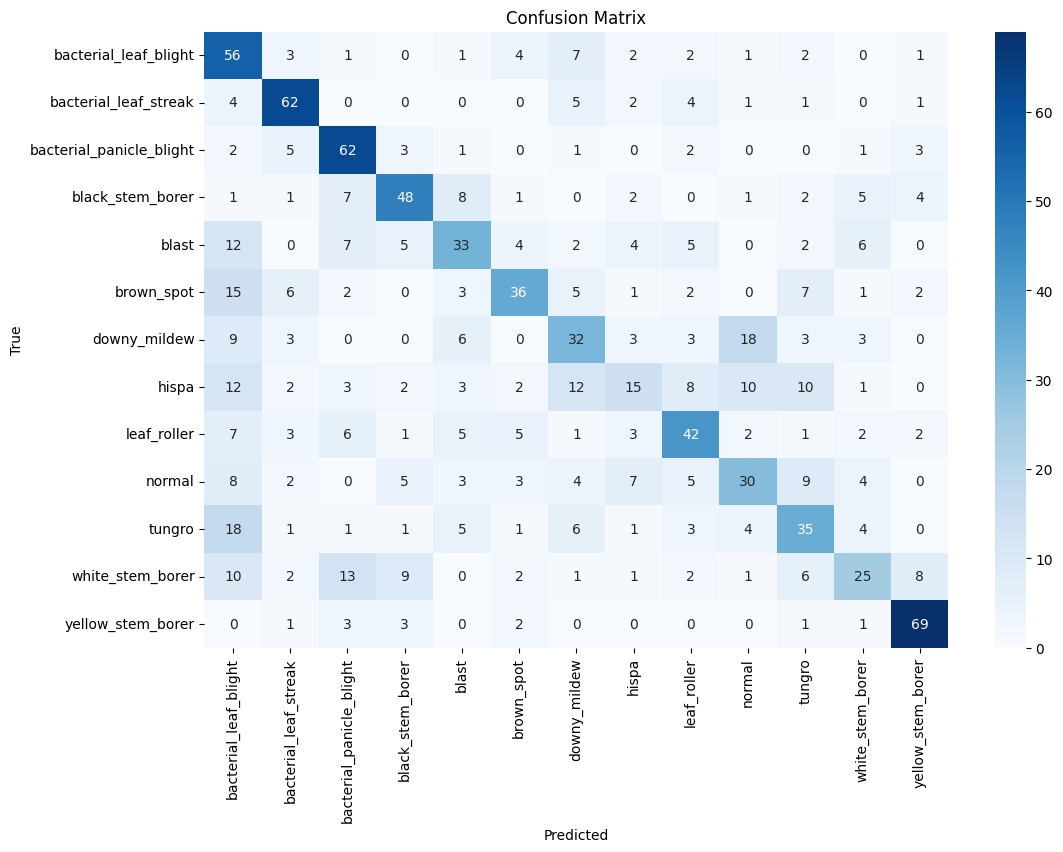


📦 Total Parameters: 29267053
convnext_tiny: 180 weight tensors
global_average_pooling2d_7: 0 weight tensors
flatten_4: 0 weight tensors
dense_28: 2 weight tensors
dropout_18: 0 weight tensors
dense_29: 2 weight tensors
dropout_19: 0 weight tensors
dense_30: 2 weight tensors
dropout_20: 0 weight tensors
dense_31: 2 weight tensors


I0000 00:00:1756293087.935198      36 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
I0000 00:00:1756293087.935405      36 single_machine.cc:361] Starting new session
I0000 00:00:1756293087.937584      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756293087.937780      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [10]:
# ==============================
# ConvNeXt (No Fine-Tuning) for Paddy Leaf Dataset (No Validation)
# ==============================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ==============================
# PATHS (Adjust for Kaggle)
# ==============================
train_dir = "/kaggle/input/paddy-leaf-small/Small-80/train"
test_dir = "/kaggle/input/paddy-leaf-small/Small-80/test"
pretrained_weights = "/kaggle/input/convnext/convnext_tiny_notop.h5"

img_size = 224
batch_size = 32
seed = 42

# ==============================
# DATA AUGMENTATION (TRAIN & TEST)
# ==============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
print(f"✅ Classes: {num_classes}")

# ==============================
# MODEL ARCHITECTURE (ConvNeXt Frozen)
# ==============================
base_model = ConvNeXtTiny(
    include_top=False,
    weights=pretrained_weights,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False  # ❌ No fine-tuning

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ==============================
# CALLBACKS
# ==============================
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_convnext_model.h5', monitor='accuracy', save_best_only=True)

# ==============================
# TRAIN MODEL (Full Train Data, No Validation)
# ==============================
history = model.fit(
    train_gen,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

# ==============================
# EVALUATION
# ==============================
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

# ==============================
# PLOT TRAINING CURVES
# ==============================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# ==============================
# CONFUSION MATRIX & CLASS REPORT
# ==============================
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ==============================
# PARAMETERS & WEIGHTS
# ==============================
print(f"\n📦 Total Parameters: {model.count_params()}")
for layer in model.layers:
    print(f"{layer.name}: {len(layer.get_weights())} weight tensors")

# ==============================
# GFLOPs CALCULATION
# ==============================
def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(tf.TensorSpec([1, img_size, img_size, 3], tf.float32))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    tf_graph = frozen_func.graph

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(tf_graph.as_graph_def(), name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

flops = get_flops(model)
print(f"\n⚡ Approx GFLOPs: {flops/1e9:.3f} GFLOPs")
